<a href="https://colab.research.google.com/github/mengusabah/ENS491-492-MAML/blob/main/maml_nn_log_mean_var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpyxl

You should consider upgrading via the 'C:\Users\WS4\Desktop\pythonProject\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
# import libraries and read data from excel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import lines
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
df = pd.read_excel("data_agg_new.xlsx")

In [ ]:
# make our data frame a python dictionary by grouping by PEVQS
df_dict = dict(tuple(df.groupby("PEVQS_INITIAL_BUFFERING_DELAY")))

# eliminating all the features but RSRP
for k,v in df_dict.items():
  df_dict[k] = v["RSRP_PCELL_1"]

# there are sessions with too less datapoints such as 4 datapoint etc
# eliminated such sessions
for k,v in df_dict.copy().items():
  if v.shape[0] < 50:
    del df_dict[k]

# make sure that every session has same size
for k,v in df_dict.items():
  df_dict[k] = df_dict[k].iloc[:50]

In [ ]:
mse_list_train = []
mape_list_train = []
mse_list_test = []
mape_list_test = []

for start_point in range(2,48):
  #start_point = int(input("When do you want to start forecasting: "))
  print("Current start point:", start_point)
  datasetList = []
  trainPredictPlotList = []
  testPredictPlotList = []
  mse_list_inner_train = []
  mape_list_inner_train = []
  mse_list_inner_test = []
  mape_list_inner_test = []

  for session_no in range(len(list(df_dict.values()))):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(list(df_dict.values())[session_no].values.reshape(-1,1))

    model = Sequential()
    model.add(LSTM(1, input_shape=(1, 1)))
    if session_no != 0:
      model.layers[0].set_weights(last_weight)
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(dataset[0:start_point-1], dataset[1:start_point], epochs=100, batch_size=1, verbose=0)
    print("Session {0} is done.".format(session_no))

    # getting latest weight of the previous model
    last_weight = model.layers[-2].get_weights()

    # make predictions
    trainPredict = model.predict(dataset[0:start_point-1])
    testPredict = model.predict(dataset[start_point:-2])

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(dataset[1:start_point])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(dataset[start_point+1:-1])

    # calculate mean squared error
    trainScore_MSE = mean_squared_error(trainY[:,0], trainPredict[:,0])
    print("Session {0} Train Score: {1} MSE".format(session_no, trainScore_MSE))
    mse_list_inner_train.append(trainScore_MSE)

    testScore_MSE = mean_squared_error(testY[:,0], testPredict[:,0])
    print("Session {0} Test Score: {1} MSE".format(session_no, testScore_MSE))
    mse_list_inner_test.append(testScore_MSE)


    # calculate mean absolute percentage error
    trainScore_MAPE = mean_absolute_percentage_error(trainY[:,0], trainPredict[:,0]) * 100
    print("Session {0} Train Score: {1} MAPE".format(session_no, trainScore_MAPE))
    mape_list_inner_train.append(trainScore_MAPE)

    testScore_MAPE = mean_absolute_percentage_error(testY[:,0], testPredict[:,0]) * 100
    print("Session {0} Test Score: {1} MAPE\n".format(session_no, testScore_MAPE))
    mape_list_inner_test.append(testScore_MAPE)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(1*2):len(dataset)-1, :] = testPredict

    # storing plots
    datasetList.append(scaler.inverse_transform(dataset))
    trainPredictPlotList.append(trainPredictPlot)
    testPredictPlotList.append(testPredictPlot)
  mse_list_train.append(mse_list_inner_train)
  mse_list_test.append(mse_list_inner_test)
  mape_list_train.append(mape_list_inner_train)
  mape_list_test.append(mape_list_inner_test)

Current start point: 2
Session 0 is done.
2/2 [==============================] - 0s 3ms/step
Session 0 Train Score: 44.63789858674863 MSE
Session 0 Test Score: 37.77024423164498 MSE
Session 0 Train Score: 7.184042981875841 MAPE
Session 0 Test Score: 5.893839069926942 MAPE

Session 1 is done.
2/2 [==============================] - 0s 3ms/step
Session 1 Train Score: 1.026783138513565e-05 MSE
Session 1 Test Score: 79.1144212644203 MSE
Session 1 Train Score: 0.0036831559806034483 MAPE
Session 1 Test Score: 10.734423938896077 MAPE

Session 2 is done.
2/2 [==============================] - 0s 997us/step
Session 2 Train Score: 0.14309047028655186 MSE
Session 2 Test Score: 5.610512540146774 MSE
Session 2 Train Score: 0.43479656351023704 MAPE
Session 2 Test Score: 2.123920243274636 MAPE

Session 3 is done.
2/2 [==============================] - 0s 2ms/step
Session 3 Train Score: 9.68948006638791e-06 MSE
Session 3 Test Score: 51.88156048823706 MSE
Session 3 Train Score: 0.003144235321984051 MAPE

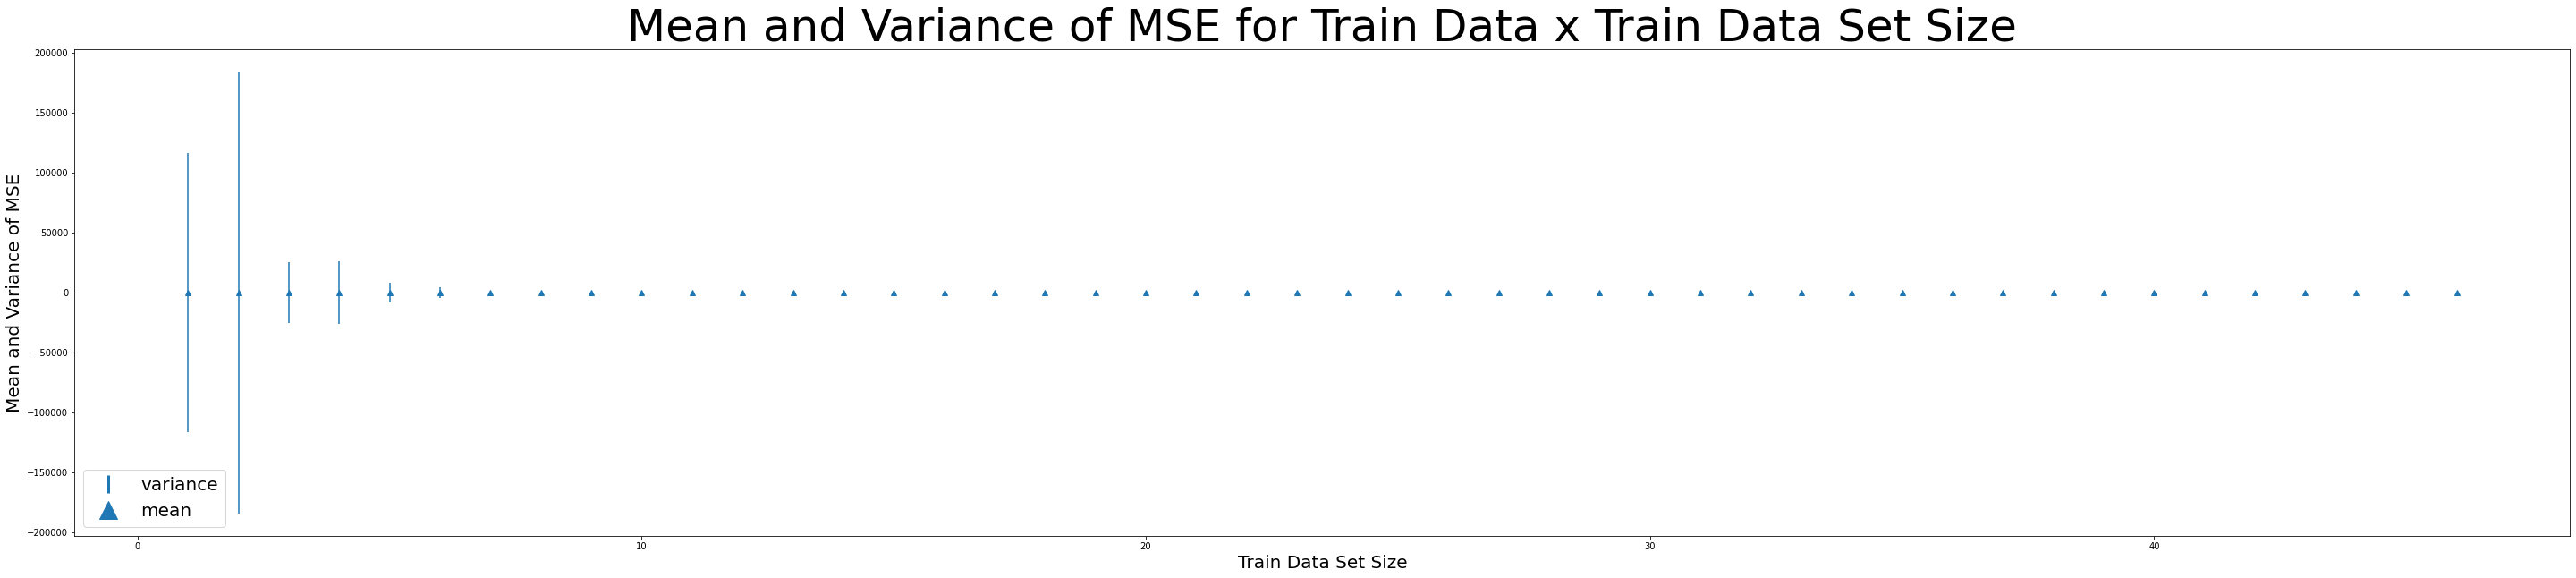

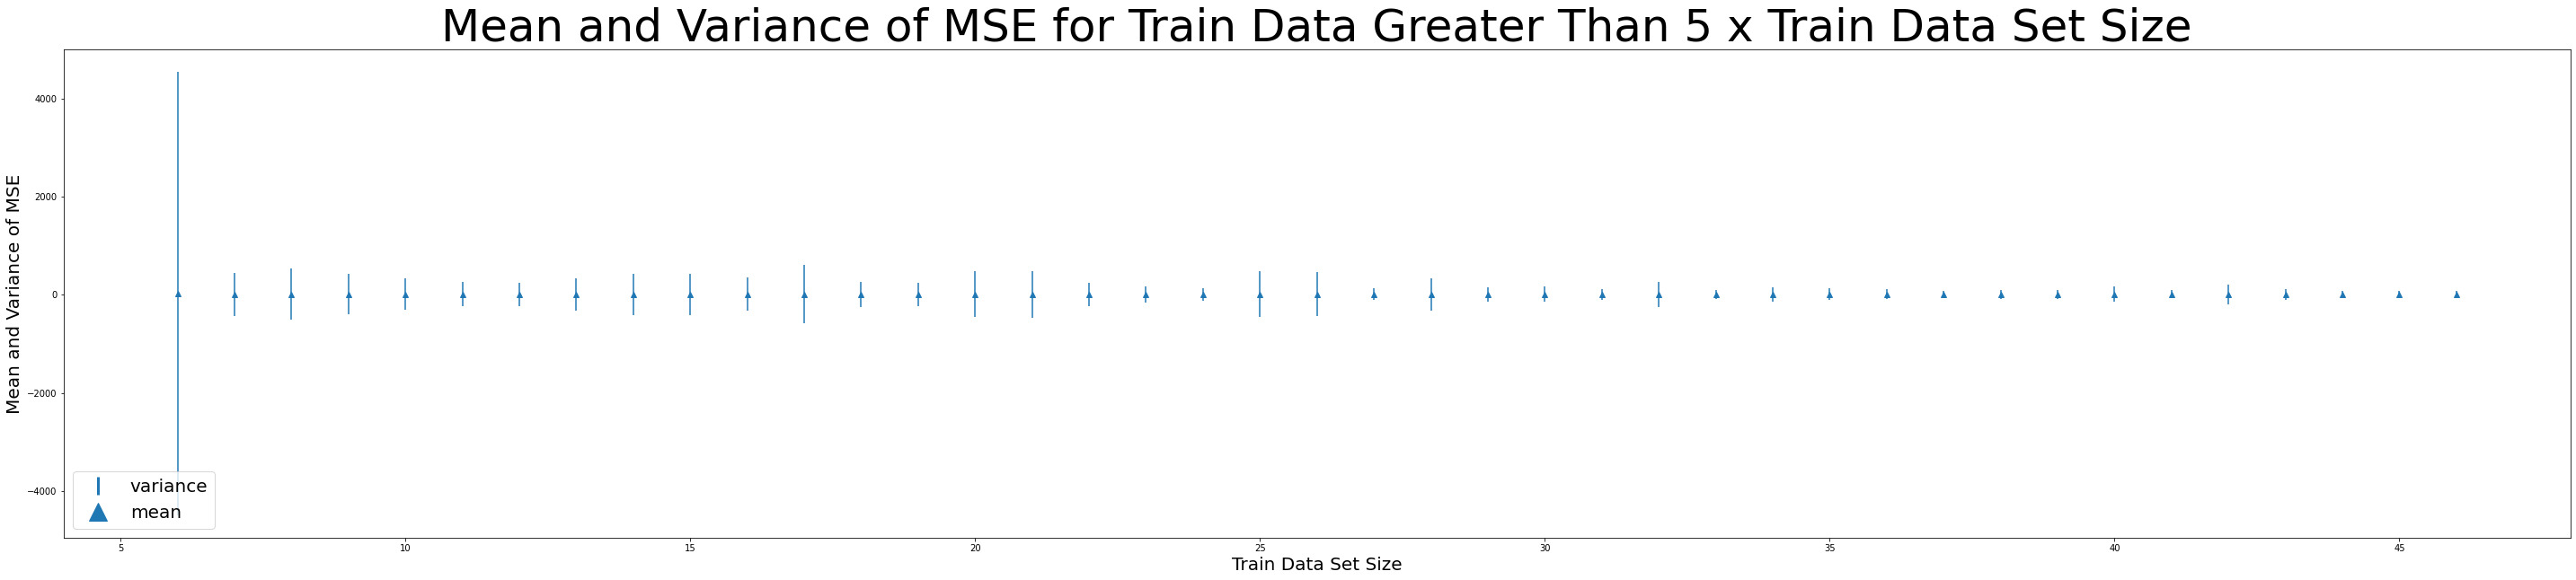

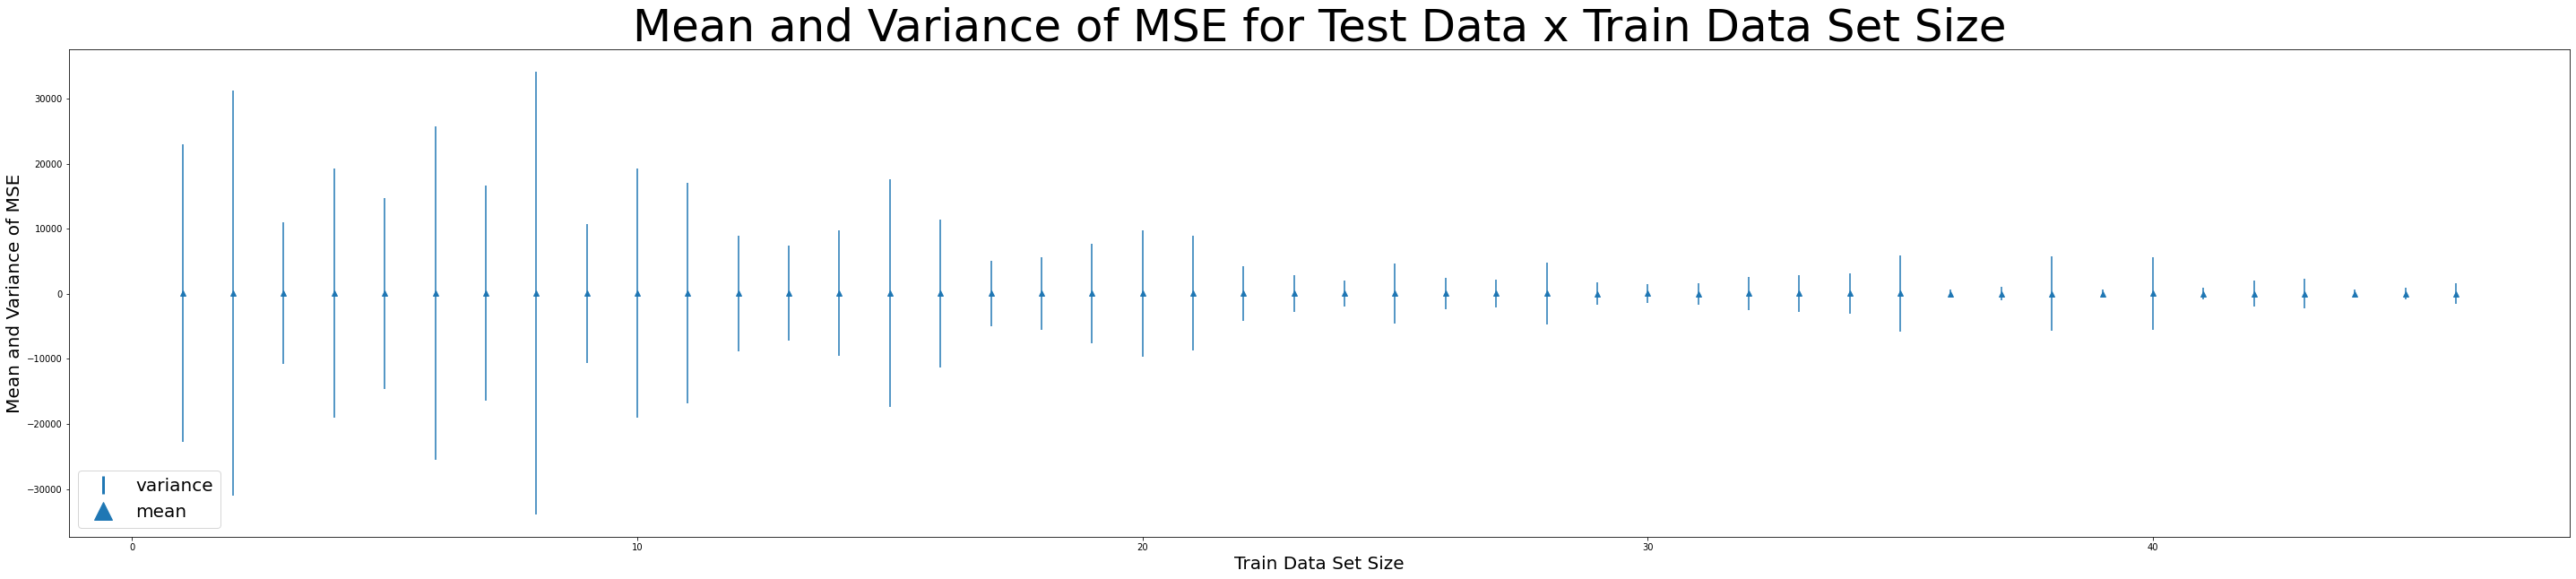

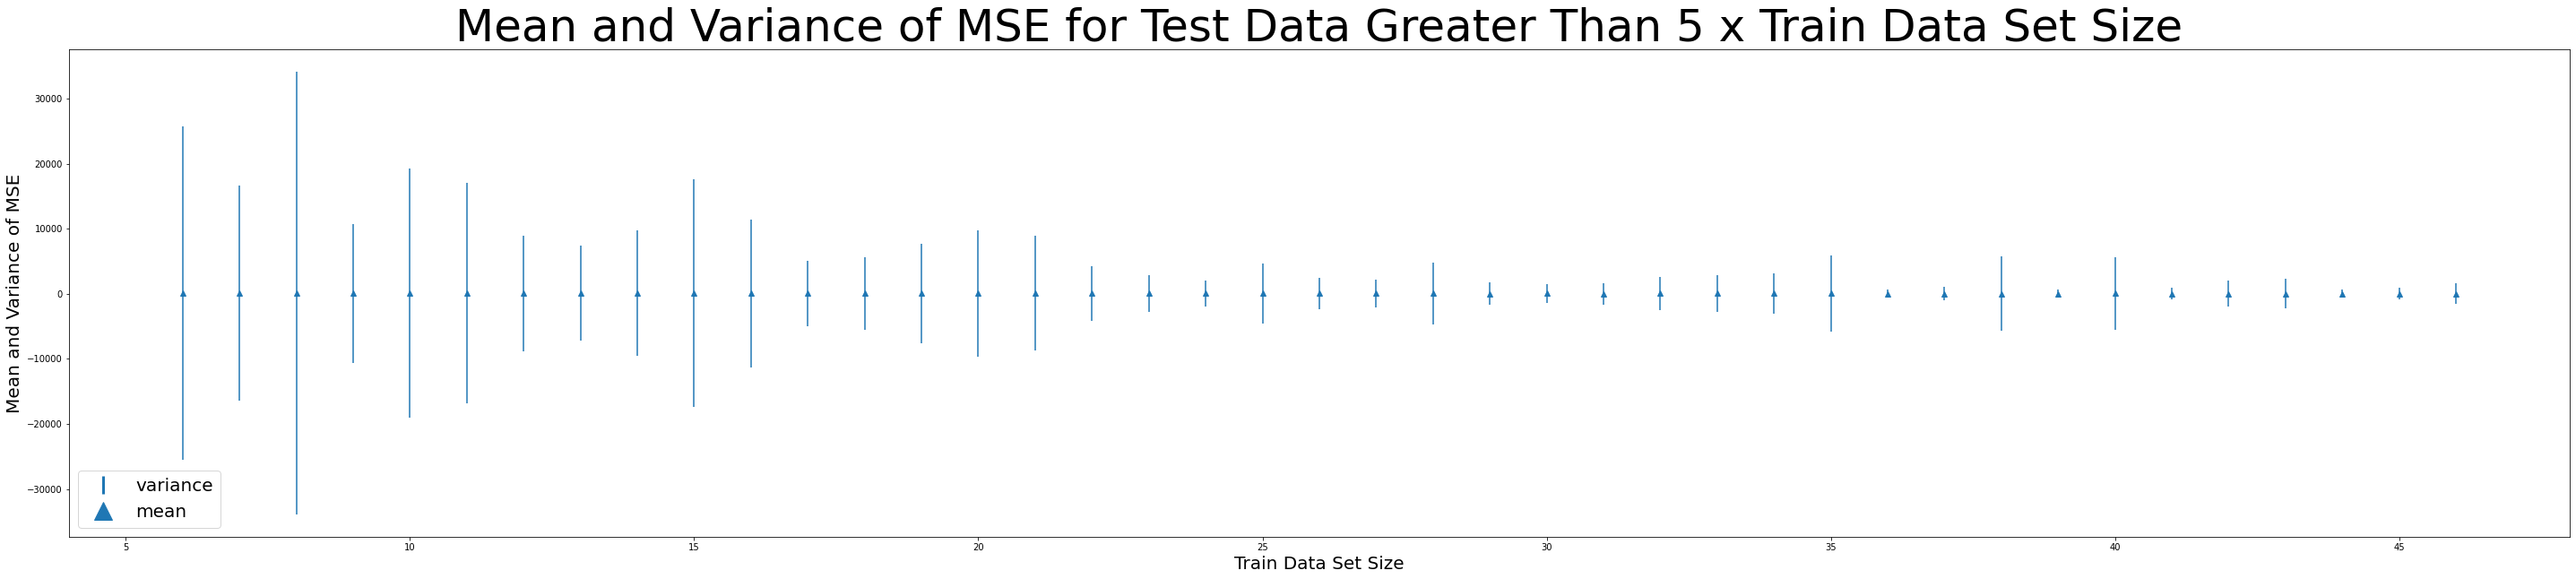

In [ ]:
mse_means_train = np.mean(np.array(mse_list_train), axis = 1)
mse_var_train = np.var(np.array(mse_list_train), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Mean and Variance of MSE", fontsize = 20)
ax.errorbar(list(range(1, 47)), mse_means_train, mse_var_train, linestyle="None", marker="^")
plt.title("Mean and Variance of MSE for Train Data x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mse_means_train = np.mean(np.array(mse_list_train), axis = 1)
mse_var_train = np.var(np.array(mse_list_train), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Mean and Variance of MSE", fontsize = 20)
ax.errorbar(list(np.asarray(list(range(1, 42)))+5), mse_means_train[5:], mse_var_train[5:], linestyle="None", marker="^")
plt.title("Mean and Variance of MSE for Train Data Greater Than 5 x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mse_means_test = np.mean(np.array(mse_list_test), axis = 1)
mse_var_test = np.var(np.array(mse_list_test), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Mean and Variance of MSE", fontsize = 20)
plt.errorbar(list(range(1, 47)), mse_means_test, mse_var_test, linestyle="None", marker="^")
plt.title("Mean and Variance of MSE for Test Data x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mse_means_test = np.mean(np.array(mse_list_test), axis = 1)
mse_var_test = np.var(np.array(mse_list_test), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Mean and Variance of MSE", fontsize = 20)
plt.errorbar(list(np.asarray(list(range(1, 42)))+5), mse_means_test[5:], mse_var_test[5:], linestyle="None", marker="^")
plt.title("Mean and Variance of MSE for Test Data Greater Than 5 x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

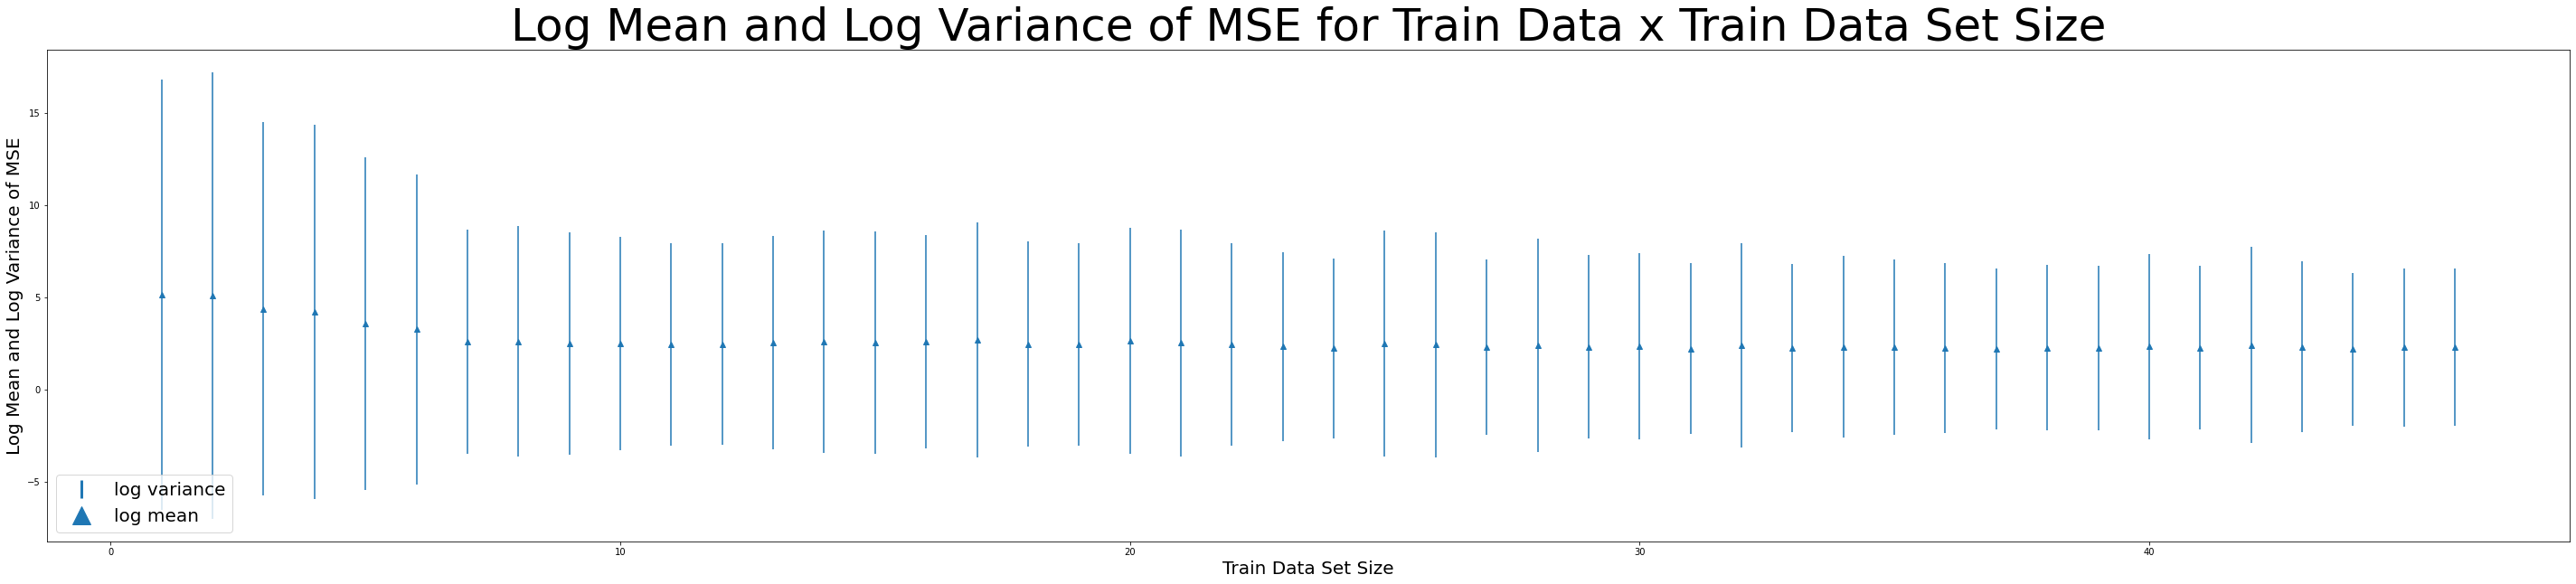

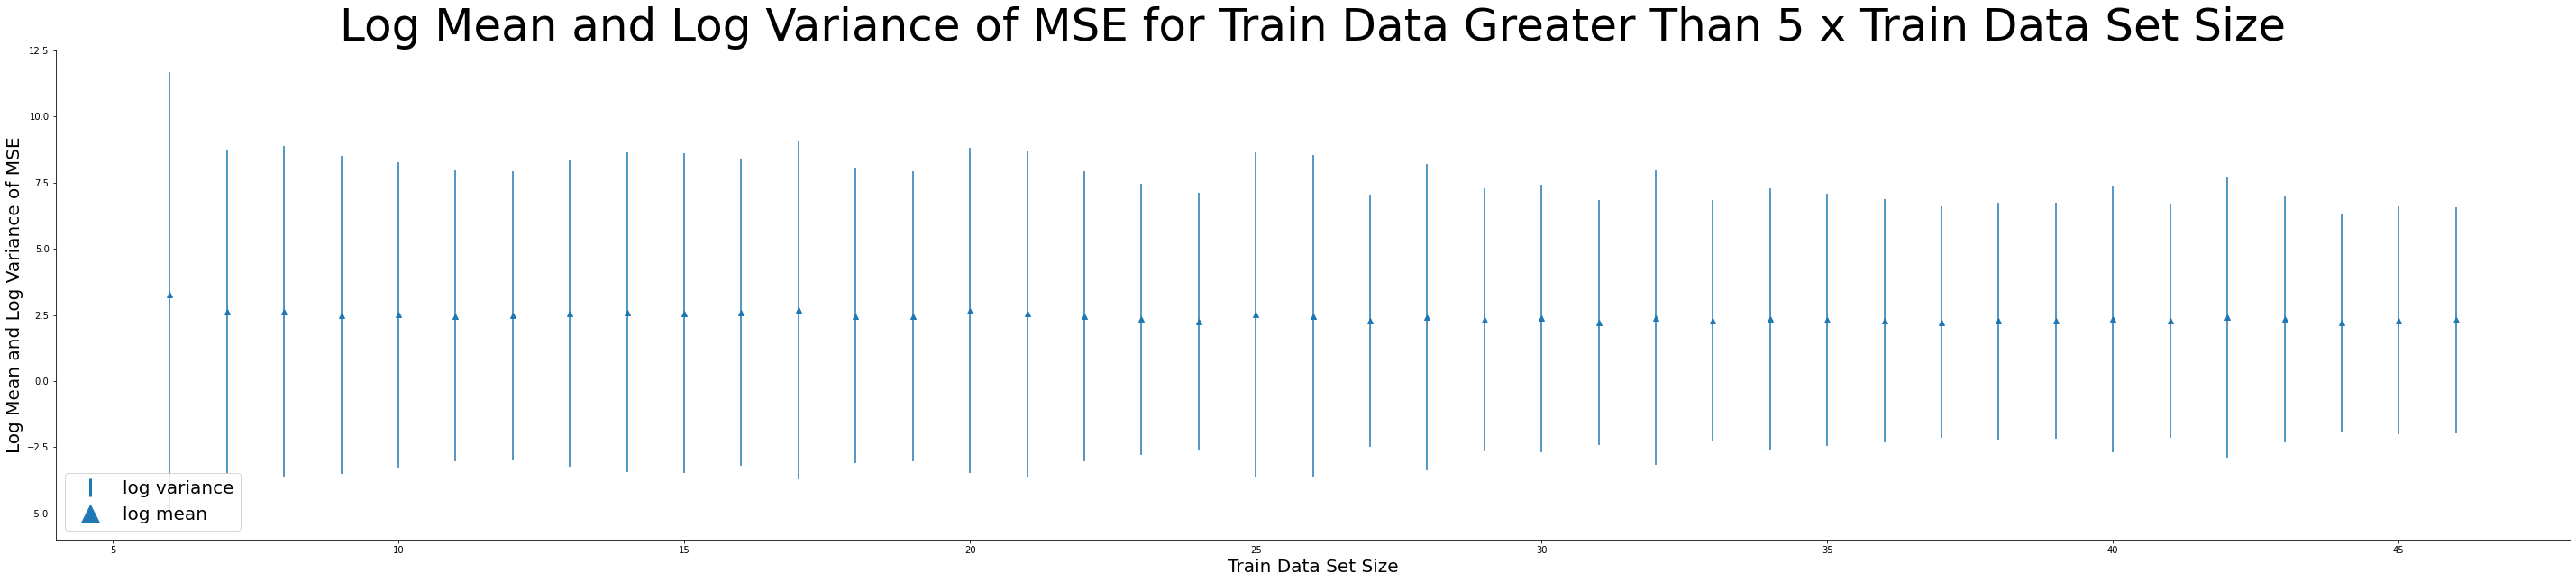

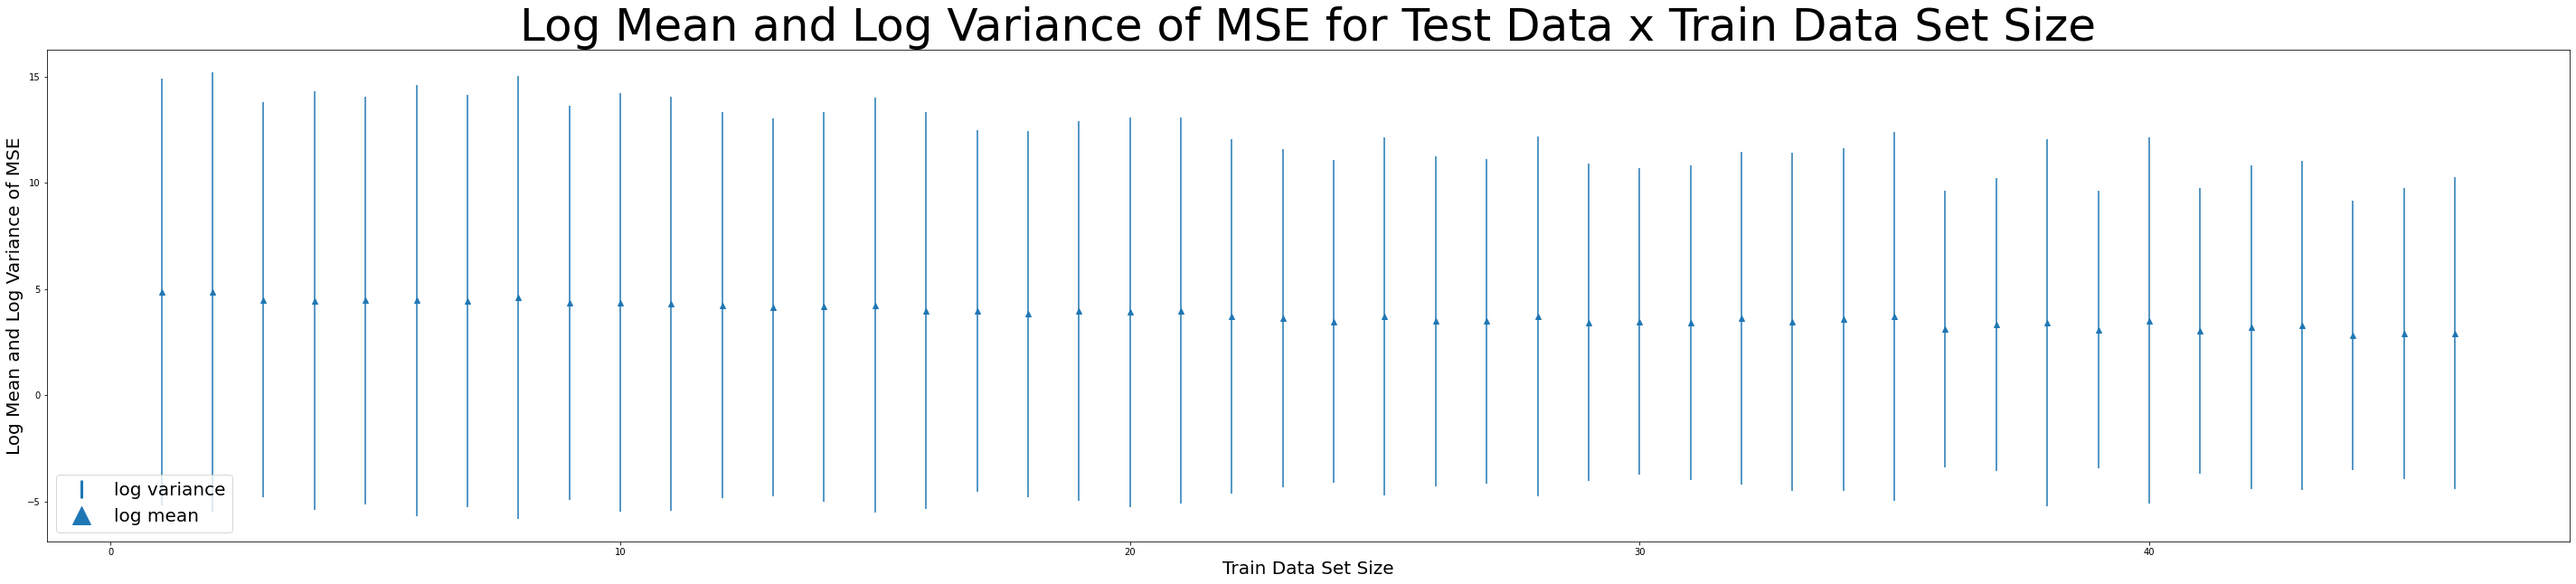

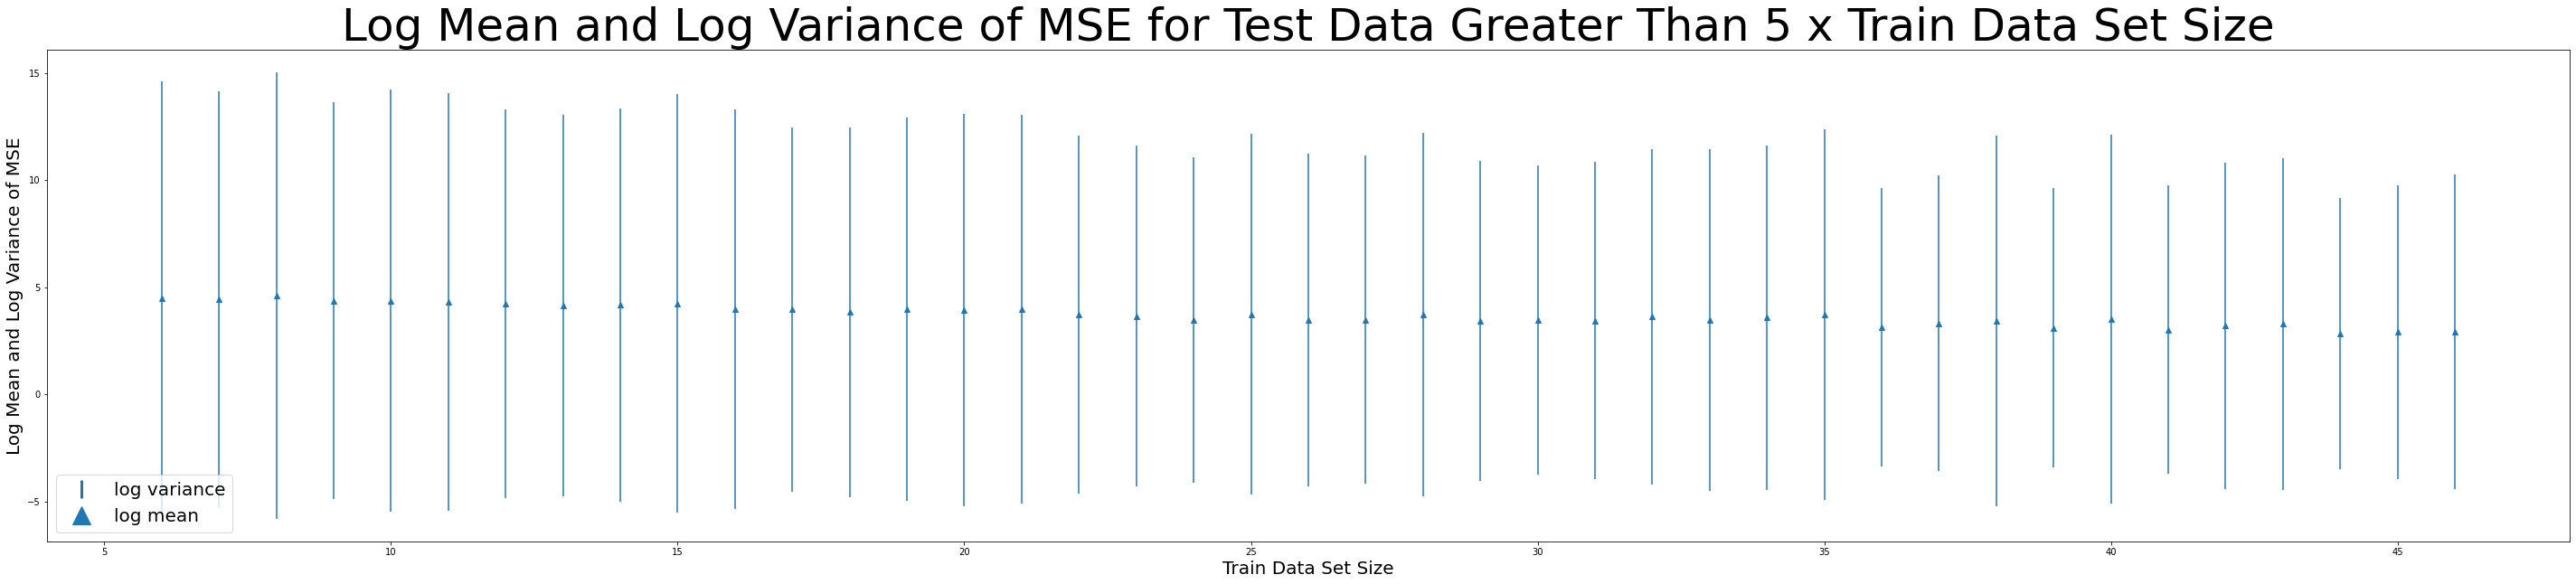

In [ ]:
mse_means_train = np.mean(np.array(mse_list_train), axis = 1)
mse_var_train = np.var(np.array(mse_list_train), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Log Mean and Log Variance of MSE", fontsize = 20)
ax.errorbar(list(range(1, 47)), np.log(mse_means_train), np.log(mse_var_train), linestyle="None", marker="^")
plt.title("Log Mean and Log Variance of MSE for Train Data x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='log variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='log mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mse_means_train = np.mean(np.array(mse_list_train), axis = 1)
mse_var_train = np.var(np.array(mse_list_train), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Log Mean and Log Variance of MSE", fontsize = 20)
ax.errorbar(list(np.asarray(list(range(1, 42)))+5), np.log(mse_means_train[5:]), np.log(mse_var_train[5:]), linestyle="None", marker="^")
plt.title("Log Mean and Log Variance of MSE for Train Data Greater Than 5 x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='log variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='log mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mse_means_test = np.mean(np.array(mse_list_test), axis = 1)
mse_var_test = np.var(np.array(mse_list_test), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Log Mean and Log Variance of MSE", fontsize = 20)
plt.errorbar(list(range(1, 47)), np.log(mse_means_test), np.log(mse_var_test), linestyle="None", marker="^")
plt.title("Log Mean and Log Variance of MSE for Test Data x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='log variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='log mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mse_means_test = np.mean(np.array(mse_list_test), axis = 1)
mse_var_test = np.var(np.array(mse_list_test), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Log Mean and Log Variance of MSE", fontsize = 20)
plt.errorbar(list(np.asarray(list(range(1, 42)))+5), np.log(mse_means_test[5:]), np.log(mse_var_test[5:]), linestyle="None", marker="^")
plt.title("Log Mean and Log Variance of MSE for Test Data Greater Than 5 x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='log variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='log mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

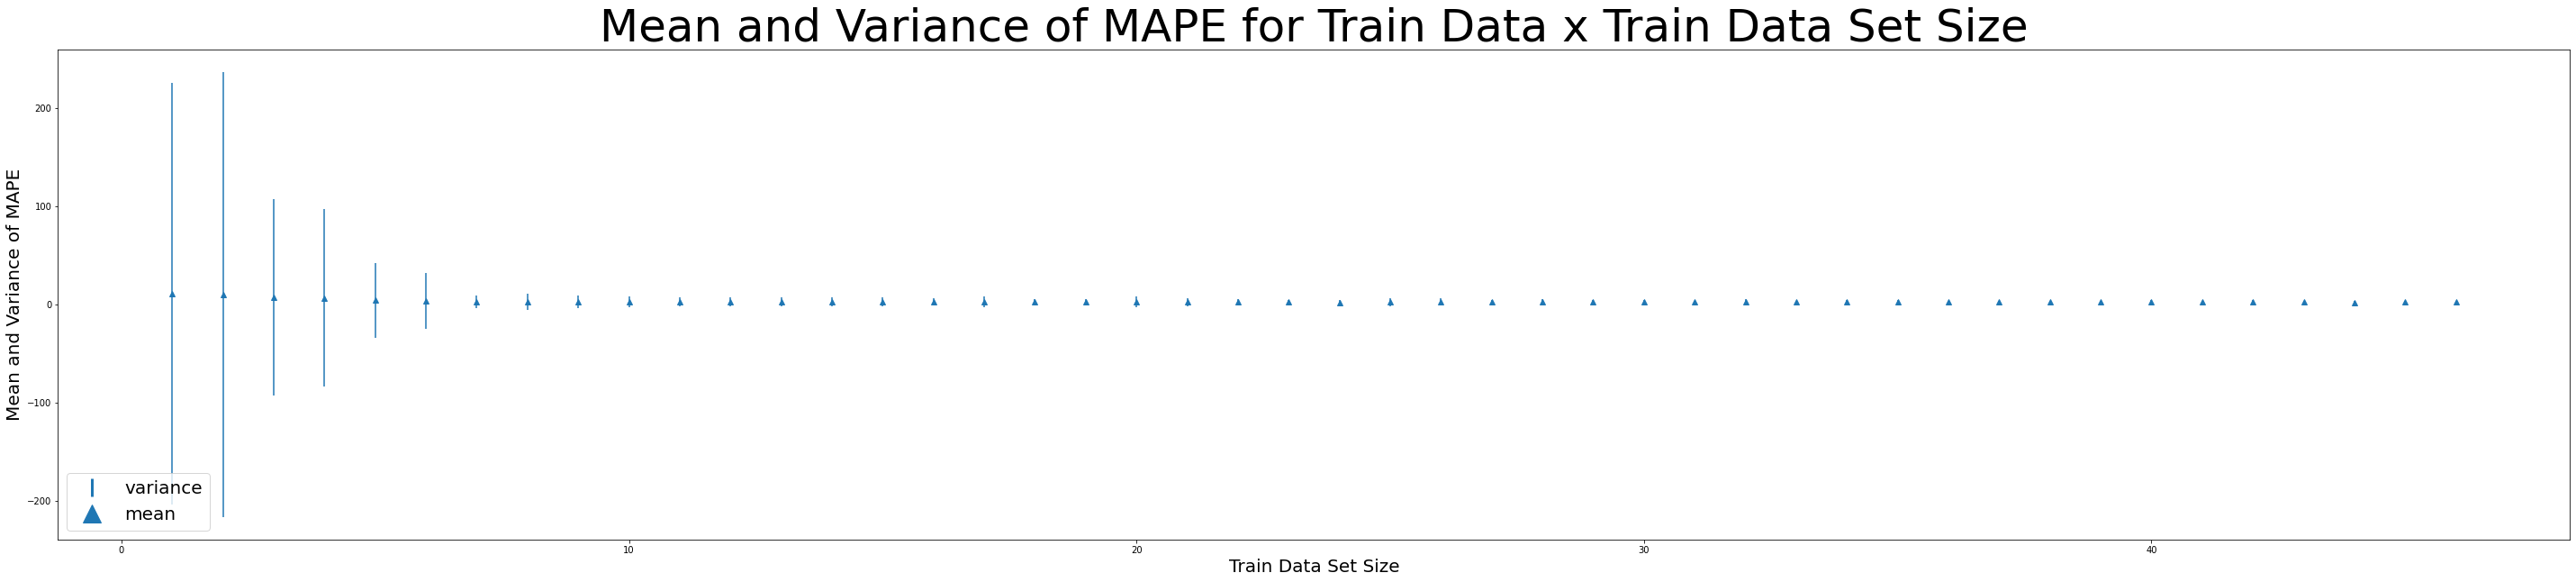

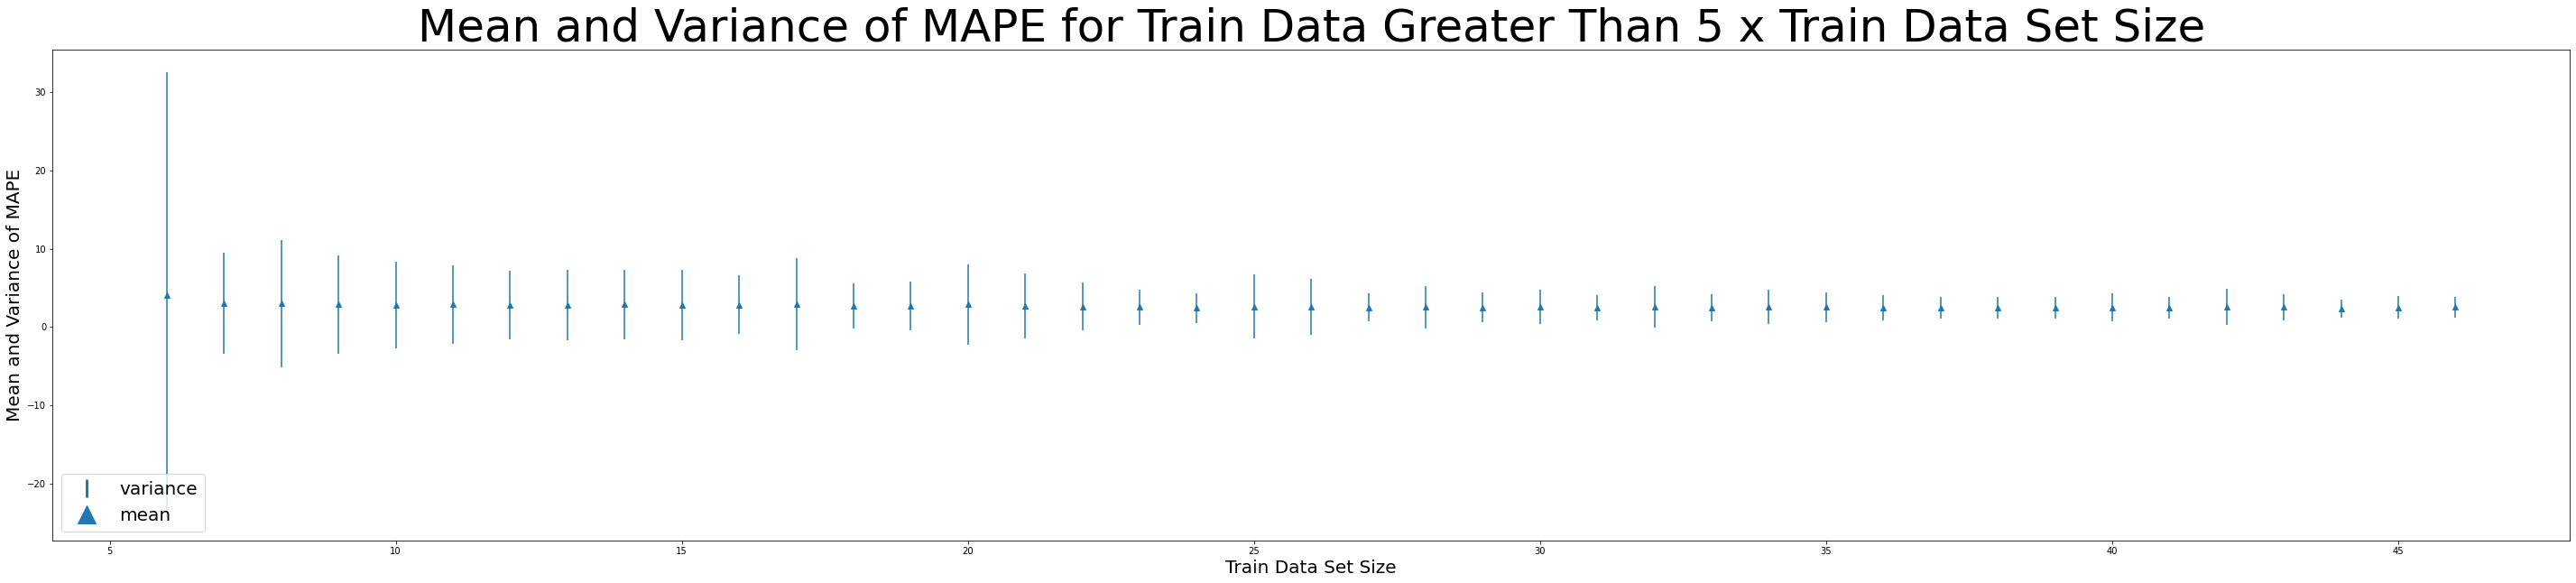

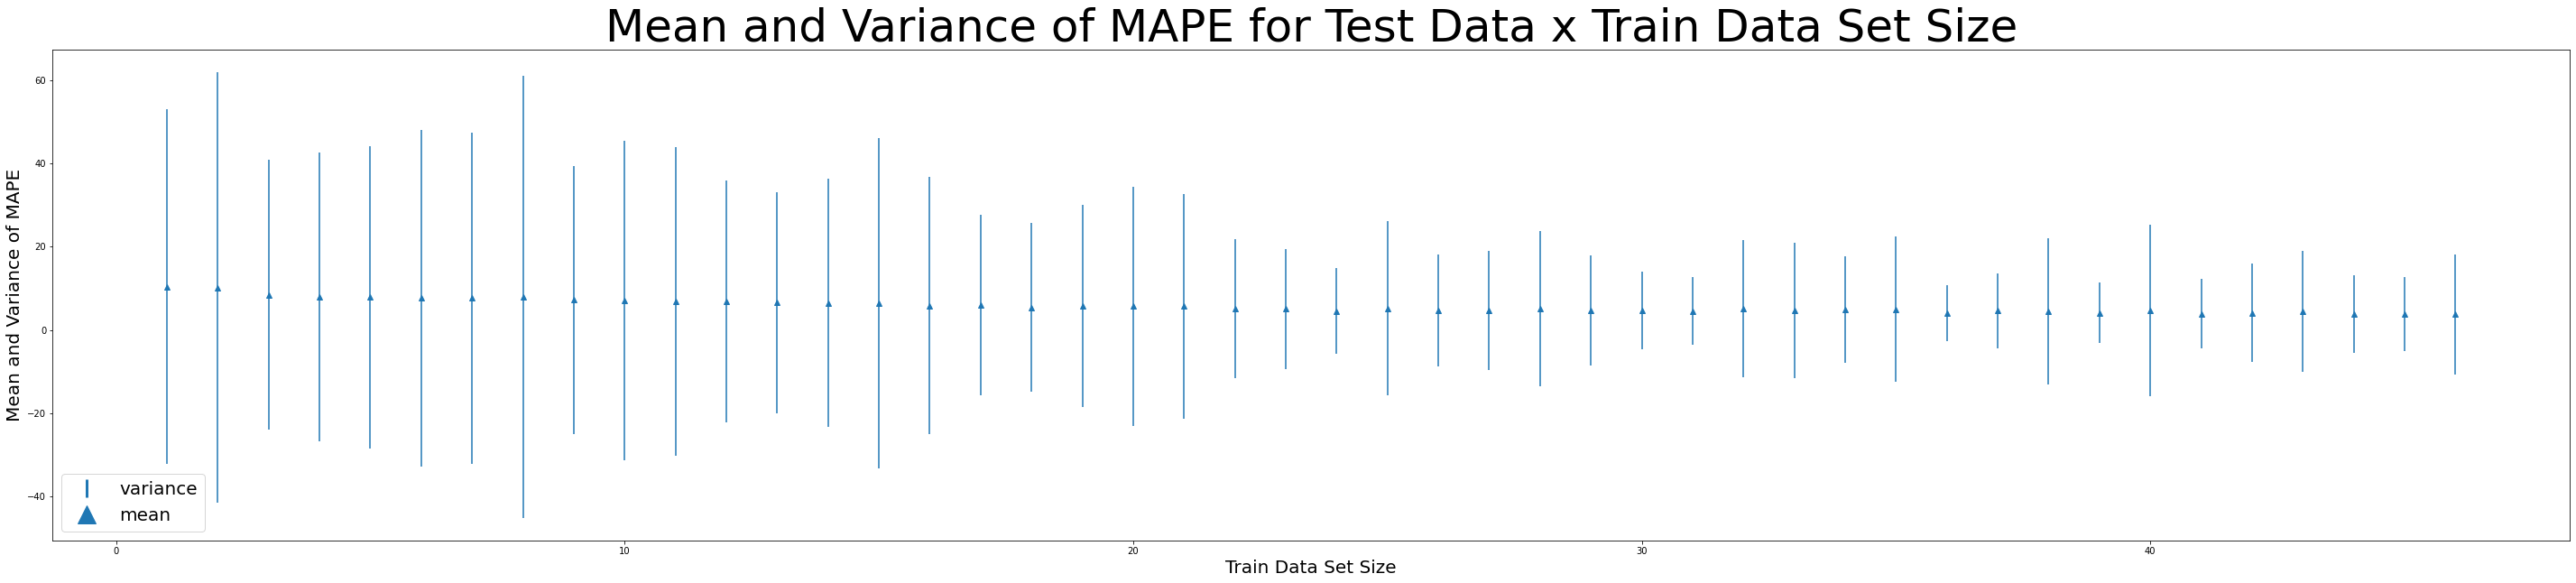

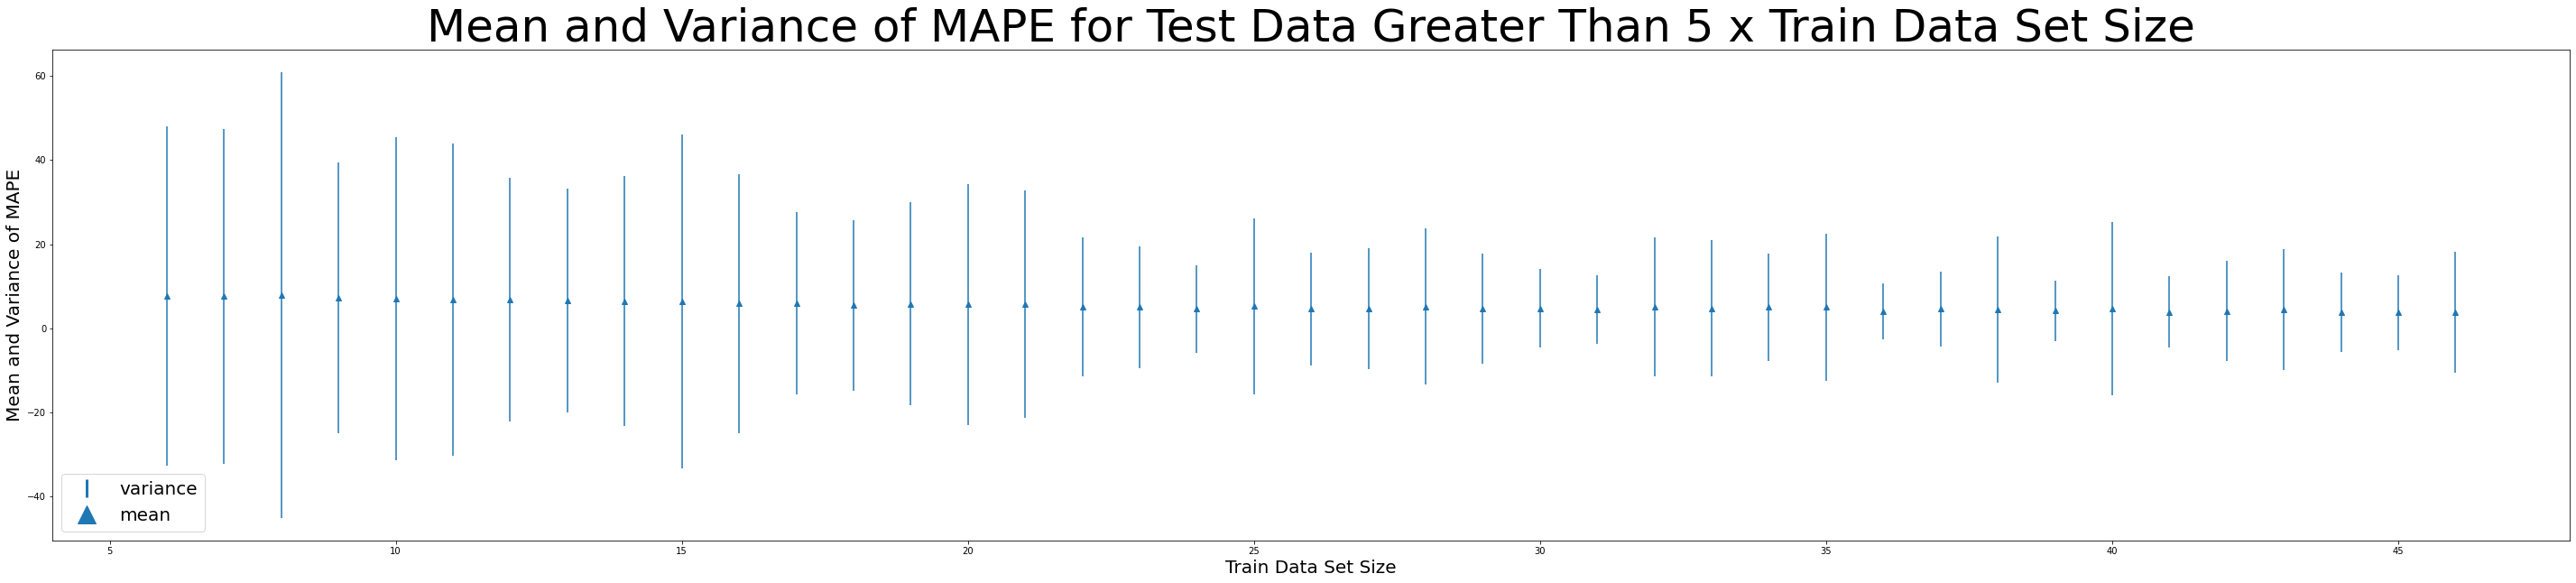

In [ ]:
mape_means_train = np.mean(np.array(mape_list_train), axis = 1)
mape_var_train = np.var(np.array(mape_list_train), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Mean and Variance of MAPE", fontsize = 20)
ax.errorbar(list(range(1, 47)), mape_means_train, mape_var_train, linestyle="None", marker="^")
plt.title("Mean and Variance of MAPE for Train Data x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mape_means_train = np.mean(np.array(mape_list_train), axis = 1)
mape_var_train = np.var(np.array(mape_list_train), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Mean and Variance of MAPE", fontsize = 20)
ax.errorbar(list(np.asarray(list(range(1, 42)))+5), mape_means_train[5:], mape_var_train[5:], linestyle="None", marker="^")
plt.title("Mean and Variance of MAPE for Train Data Greater Than 5 x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mape_means_test = np.mean(np.array(mape_list_test), axis = 1)
mape_var_test = np.var(np.array(mape_list_test), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Mean and Variance of MAPE", fontsize = 20)
plt.errorbar(list(range(1, 47)), mape_means_test, mape_var_test, linestyle="None", marker="^")
plt.title("Mean and Variance of MAPE for Test Data x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mape_means_test = np.mean(np.array(mape_list_test), axis = 1)
mape_var_test = np.var(np.array(mape_list_test), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Mean and Variance of MAPE", fontsize = 20)
plt.errorbar(list(np.asarray(list(range(1, 42)))+5), mape_means_test[5:], mape_var_test[5:], linestyle="None", marker="^")
plt.title("Mean and Variance of MAPE for Test Data Greater Than 5 x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

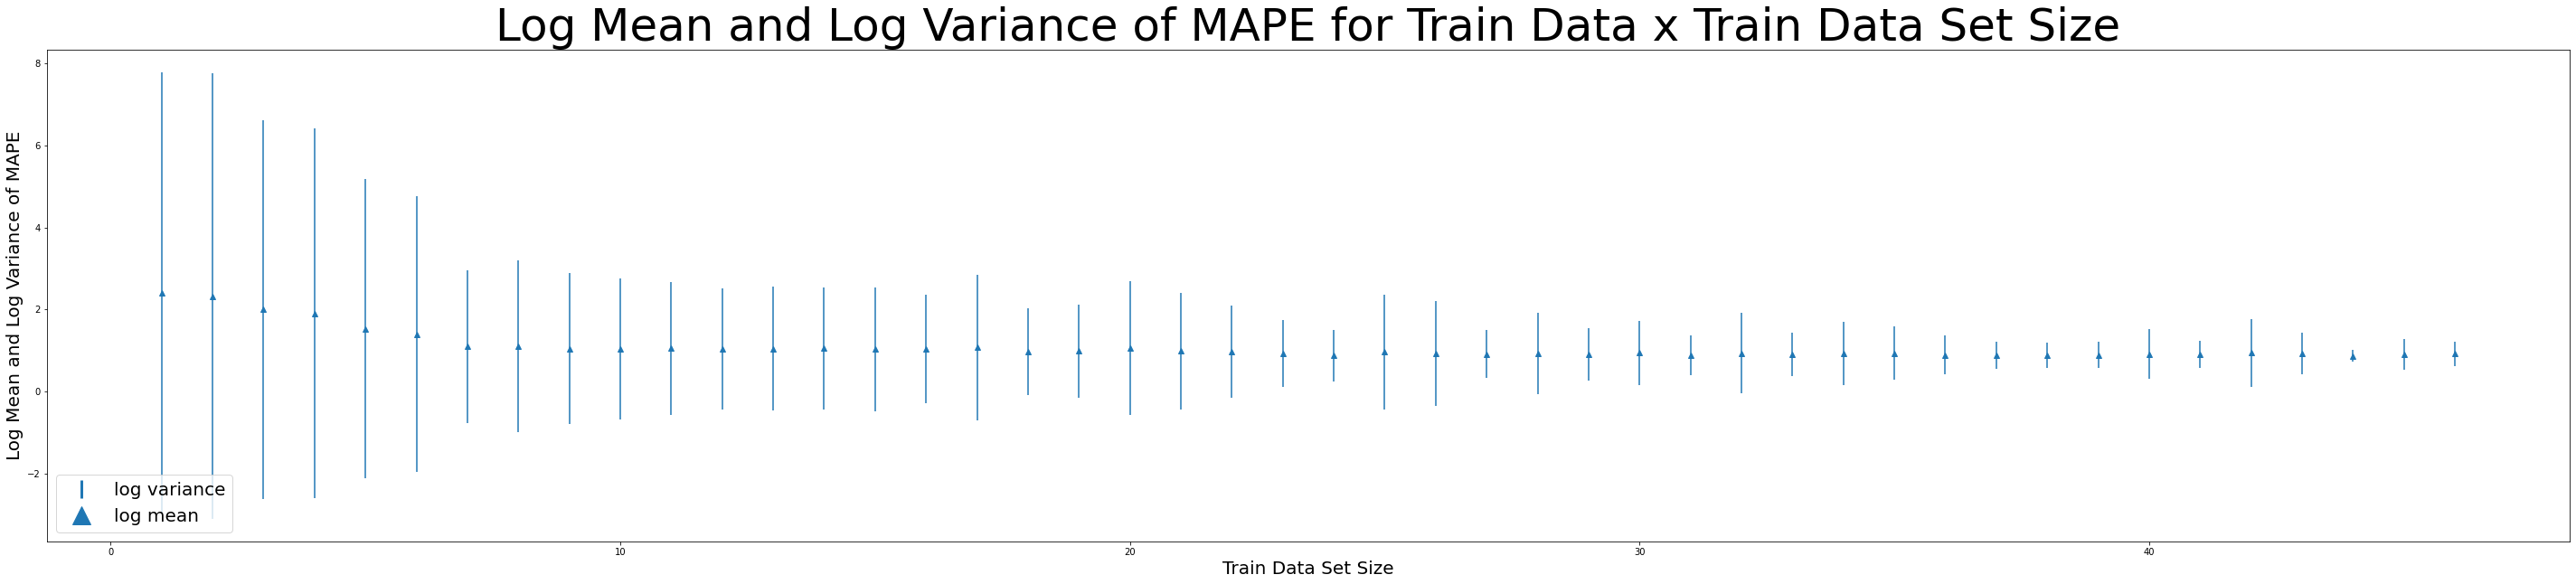

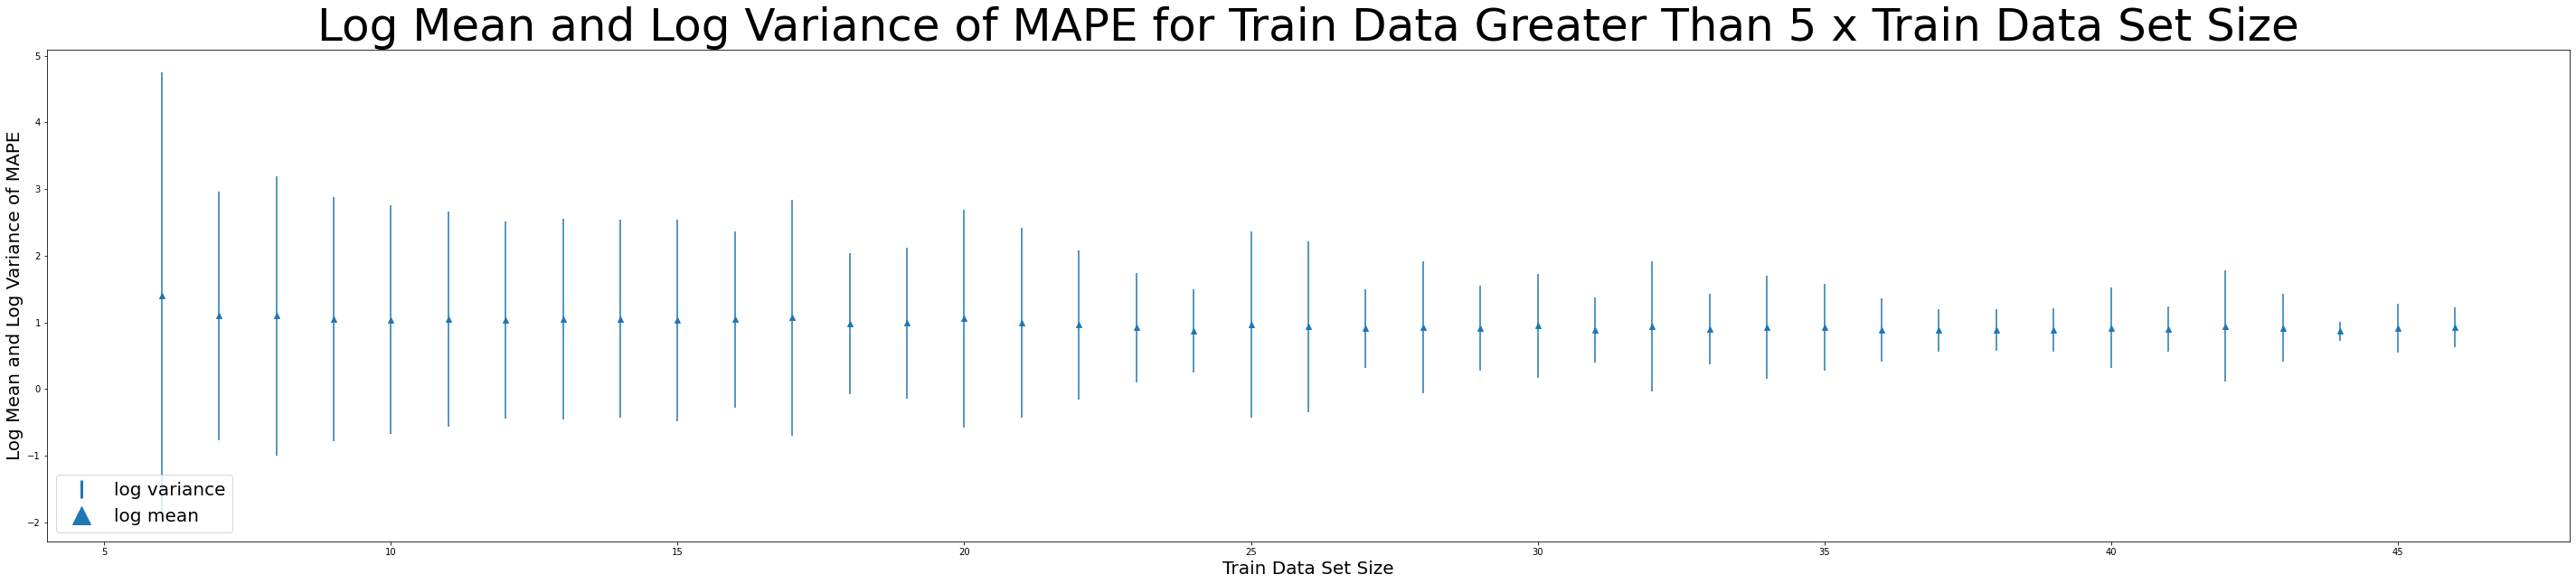

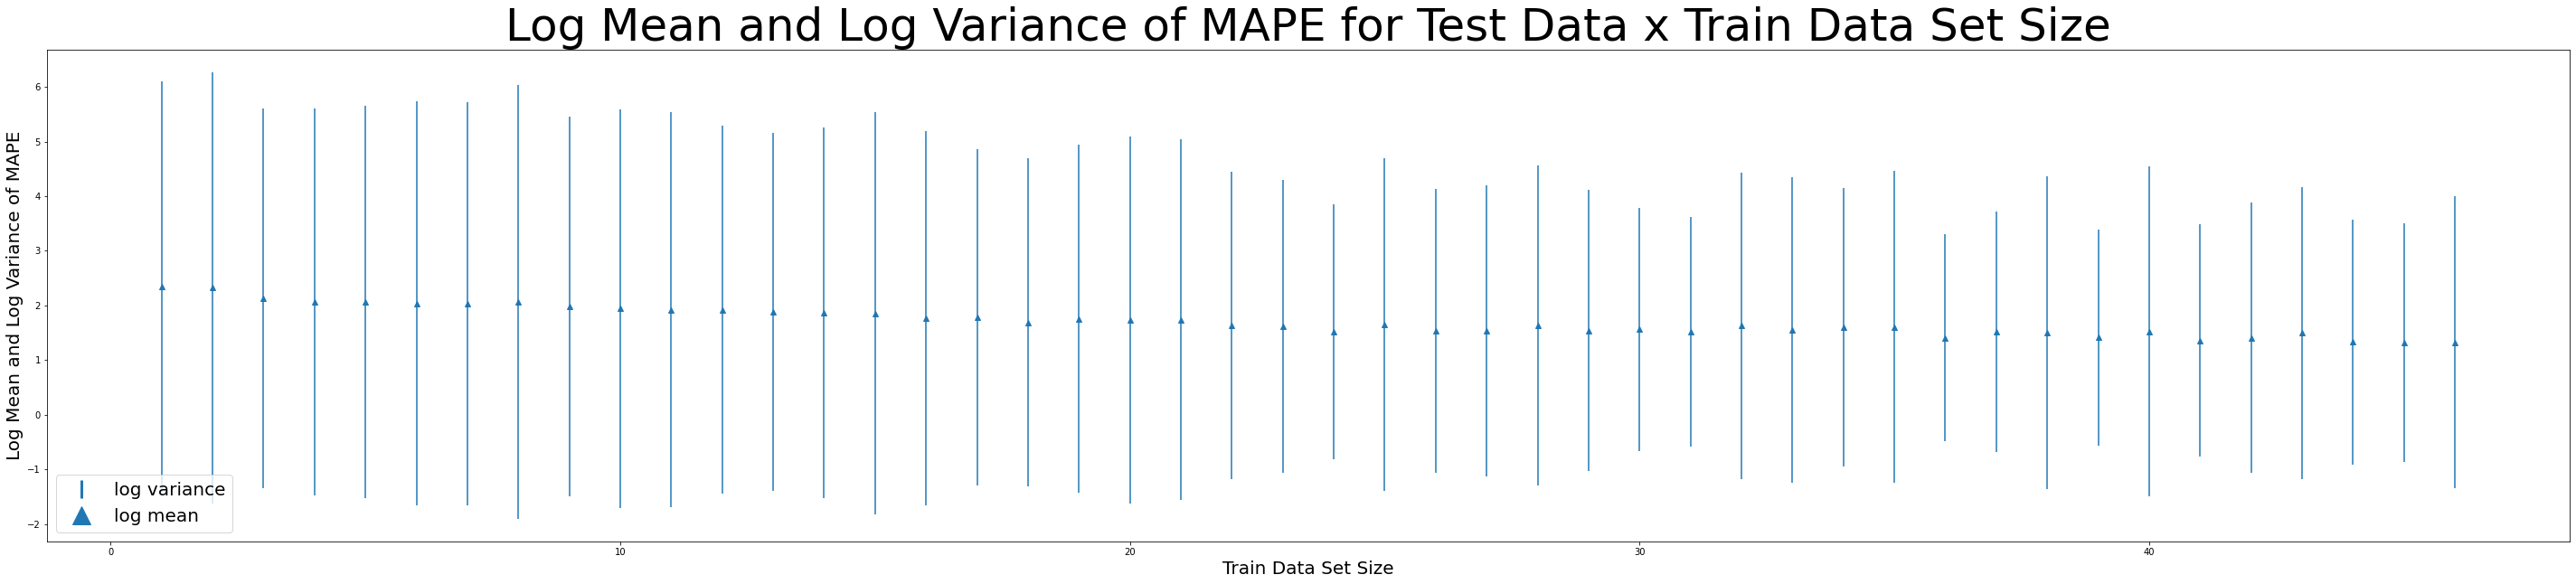

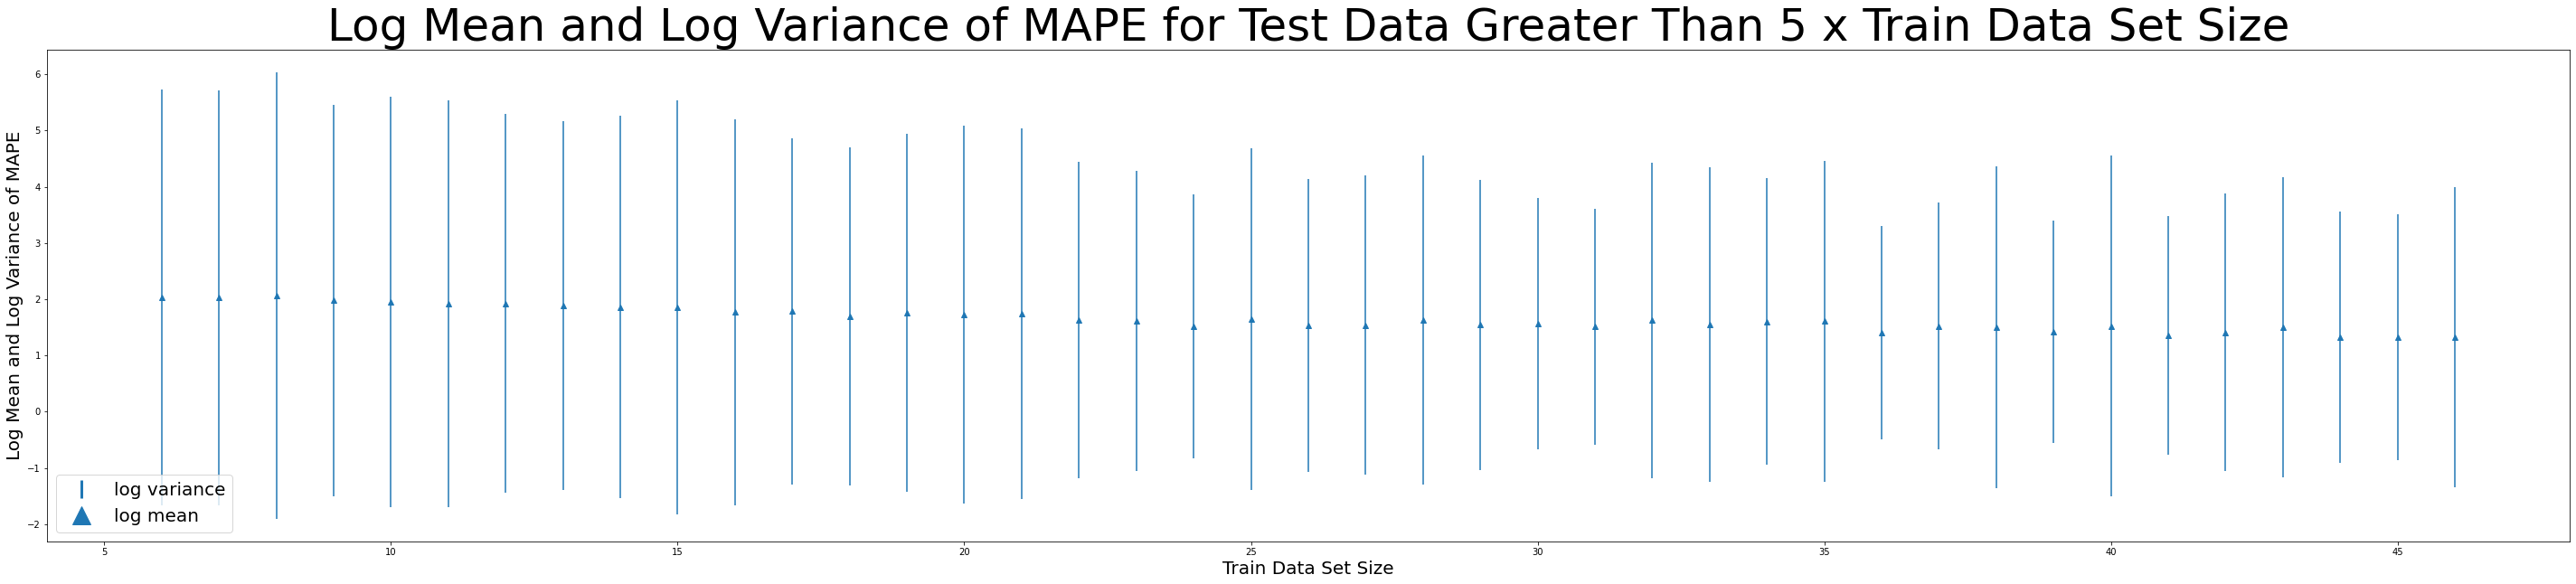

In [ ]:
mape_means_train = np.mean(np.array(mape_list_train), axis = 1)
mape_var_train = np.var(np.array(mape_list_train), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Log Mean and Log Variance of MAPE", fontsize = 20)
ax.errorbar(list(range(1, 47)), np.log(mape_means_train), np.log(mape_var_train), linestyle="None", marker="^")
plt.title("Log Mean and Log Variance of MAPE for Train Data x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='log variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='log mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mape_means_train = np.mean(np.array(mape_list_train), axis = 1)
mape_var_train = np.var(np.array(mape_list_train), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Log Mean and Log Variance of MAPE", fontsize = 20)
ax.errorbar(list(np.asarray(list(range(1, 42)))+5), np.log(mape_means_train[5:]), np.log(mape_var_train[5:]), linestyle="None", marker="^")
plt.title("Log Mean and Log Variance of MAPE for Train Data Greater Than 5 x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='log variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='log mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mape_means_test = np.mean(np.array(mape_list_test), axis = 1)
mape_var_test = np.var(np.array(mape_list_test), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Log Mean and Log Variance of MAPE", fontsize = 20)
plt.errorbar(list(range(1, 47)), np.log(mape_means_test), np.log(mape_var_test), linestyle="None", marker="^")
plt.title("Log Mean and Log Variance of MAPE for Test Data x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='log variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='log mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()

mape_means_test = np.mean(np.array(mape_list_test), axis = 1)
mape_var_test = np.var(np.array(mape_list_test), axis = 1)
fig, ax = plt.subplots(figsize = (50,10))
ax.set_xlabel("Train Data Set Size", fontsize = 20)
ax.set_ylabel("Log Mean and Log Variance of MAPE", fontsize = 20)
plt.errorbar(list(np.asarray(list(range(1, 42)))+5), np.log(mape_means_test[5:]), np.log(mape_var_test[5:]), linestyle="None", marker="^")
plt.title("Log Mean and Log Variance of MAPE for Test Data Greater Than 5 x Train Data Set Size", fontsize = 50)
vertical_line = lines.Line2D([], [], marker='|', linestyle='None',
                          markersize=20, markeredgewidth=3, label='log variance')
tri = lines.Line2D([], [], marker='^', linestyle='None',
                          markersize=20, markeredgewidth=1, label='log mean')
plt.legend(handles = [vertical_line, tri], loc ="lower left", prop={"size": 20})
plt.show()